# Single Particle Model

In this example we show how to formulate any PyBaMM battery model so that the voltage and current are states. As an example we use the Single Particle Model. At the moment this assumes the original model is set up for current control (as is the default in PyBaMM).

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

First we load an instance of the SPM

In [2]:
model = pybamm.lithium_ion.SPM()

Next we modify the model to ensure that both the current and terminal voltage appear as states. 

We first add a new "Terminal voltage variable" and an algebraic equation that sets the "Terminal voltage variable" to be equal to the model voltage. For the SPM the voltage is given by an expression involving the concentrations and current, but for other models, such as DFN, the (non-dimensional) voltage is a state of the model. The following approach ensures the _dimensional_ voltage is always a state in the model.   

Then we make current density a variable and replace all instances of the current density in the model with a current density variable. We then add an equation that prescribes the current.

All of this is handled by the function `set_up_model_for_eis` which returns the new model.

In [3]:
def set_up_model_for_eis(model, inplace=True):
    """
    Set up model so that current and voltage are states. 
    This formulation is suitable for EIS calculations in 
    the frequency domain. 
    
    Parameters
    ----------
    model : :class:`pybamm.BaseModel`
        Model to set up for EIS.
    inplace: bool, optional
        If True, modify the model in place. Otherwise, return a
        new model. Default is True.
    """ 
    pybamm.logger.info(
        "Start setting up {} for EIS".format(model.name)
    )    
    
    # Set up inplace vs not inplace
    if inplace:
        # any changes to model attributes will change new_model attributes
        # since they point to the same object
        new_model = model
    else:
        # create a copy of the model
        new_model = model.new_copy()

    # Create a voltage variable
    V_cell = pybamm.Variable("Terminal voltage variable")
    new_model.variables["Terminal voltage variable"] = V_cell
    V = new_model.variables["Terminal voltage [V]"]

    # Add an algebraic equation for the voltage variable
    new_model.algebraic[V_cell] = V_cell - V
    new_model.initial_conditions[
        V_cell
    ] = new_model.param.p.U_ref - new_model.param.n.U_ref

    # Now make current density a variable
    # To do so, we replace all instances of the current density in the
    # model with a current density variable, which is obtained from the
    # FunctionControl submodel

    # Create the FunctionControl submodel and extract variables
    external_circuit_variables = (
        pybamm.external_circuit.FunctionControl(
            model.param, None, model.options, control="algebraic"
        ).get_fundamental_variables()
    )

    # Perform the replacement
    symbol_replacement_map = {
        new_model.variables[name]: variable
        for name, variable in external_circuit_variables.items()
    }
    # Don't replace initial conditions, as these should not contain
    # Variable objects
    replacer = pybamm.SymbolReplacer(
        symbol_replacement_map, process_initial_conditions=False
    )
    replacer.process_model(new_model, inplace=True)

    # Update the algebraic equation and initial conditions for
    # FunctionControl
    # This creates an algebraic equation for the current,
    # together with the appropriate guess for the initial condition.
    # External circuit submodels are always equations on the current
    i_cell = new_model.variables["Current density variable"]
    I = new_model.variables["Current [A]"]
    I_applied = pybamm.FunctionParameter(
        "Current function [A]", {"Time [s]": pybamm.t * new_model.param.timescale}
    )
    new_model.algebraic[i_cell] = I - I_applied
    new_model.initial_conditions[
        i_cell
    ] = new_model.param.current_with_time
    
    pybamm.logger.info(
        "Finish setting up {} for EIS".format(model.name)
    )    
    
    return new_model

Let's call the function with `inplace=False` so that we can compare the new model with the original model.

In [4]:
new_model = set_up_model_for_eis(model, inplace=False)

Next we create a list of models, loop over them and create and solve simulations in the time domain.

In [5]:
models = [model, new_model]

In [6]:
sols = []

parameter_values = pybamm.ParameterValues("Chen2020")
parameter_values["Current function [A]"] = 2.5

var_pts = {
            "x_n": 5,
            "x_s": 5,
            "x_p": 5,
            "r_n": 5,
            "r_p": 5,
}

for model in models:
    sim = pybamm.Simulation(model, parameter_values=parameter_values, var_pts=var_pts)
    sol = sim.solve([0, 3600])
    sols.append(sol)

Then we can compare the results

In [7]:
pybamm.dynamic_plot(sols)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

We can see that the state vectors are different sizes, since the new model has states for the "Current density variable" and "Terminal voltage variable"

In [8]:
for sol in sols:
    print(sol.y.shape)

(11, 100)
(13, 100)


We can find the position of the new variables in the state vector as follows

In [9]:
model = sols[1].all_models[0]  # get the discretised model from the second simulation
inds = {"Current density variable": None, "Terminal voltage variable": None}
for key in inds.keys():
    variable = model.variables[key]
    variable_y_indices = np.arange(variable.first_point, variable.last_point)
    inds[key] = variable_y_indices

We see that the current density variable is in the final position and the terminal voltage variable in the entry before

In [10]:
inds

{'Current density variable': array([12]),
 'Terminal voltage variable': array([11])}

Note that to obtain the _dimensional_ current in Amps from the current density variable we must multiply by the parameter `I_typ` (this is due to how the equation has been non-dimensionalised in PyBaMM), e.g. to get the current as function of time we can do 

In [11]:
I_typ = parameter_values.evaluate(model.param.I_typ)
sols[1].y[inds["Current density variable"], :] * I_typ

DM([[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]])

As a sanity check, let's make sure the current density and terminal voltage variables agree with the current and terminal voltage predicted by the model (i.e. the variables that were already included)

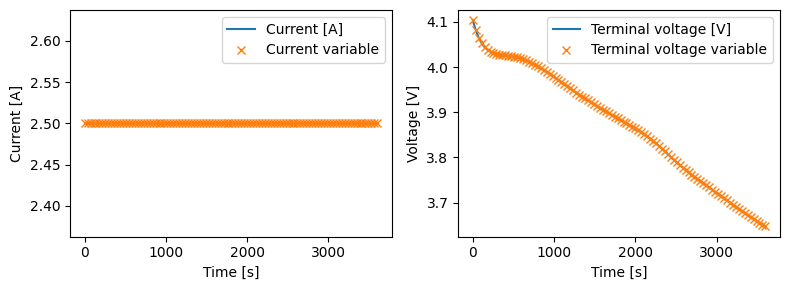

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

soln = sols[-1]

ax[0].plot(soln["Time [s]"].entries, soln["Current [A]"].entries, label="Current [A]")
ax[0].plot(soln["Time [s]"].entries, soln["Current density variable"].entries * I_typ, "x", label="Current variable")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

ax[1].plot(soln["Time [s]"].entries, soln["Terminal voltage [V]"].entries, label="Terminal voltage [V]")
ax[1].plot(soln["Time [s]"].entries, soln["Terminal voltage variable"].entries, "x", label="Terminal voltage variable")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Voltage [V]")
ax[1].legend()

plt.tight_layout();

We can get the Jacobian, $J$, out of the model. First let's look at the original formulation (for now we will do this at the initial state)

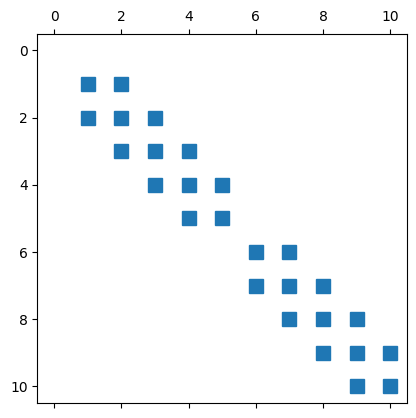

In [13]:
model = sols[0].all_models[0]
y0 = model.concatenated_initial_conditions.entries  # vector of initial conditions
J = model.jac_rhs_algebraic_eval(0, y0, []).sparse()  #  call the Jacobian and return a (sparse) matrix
plt.spy(J)

We see it is tridiagonal, except for a row of zeros at the start. This is because the model solves 2 diffusion equations, plus a single ODE of the form $dQ/dt = I$, where $Q$ is the discharge capacity.

Let's look at the reformulated model

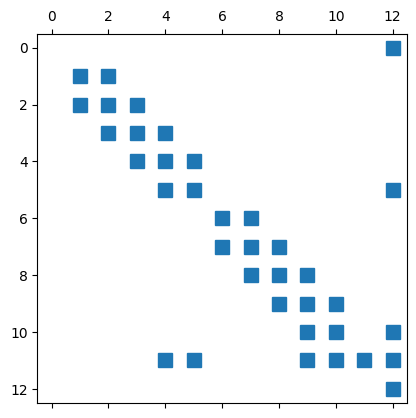

In [14]:
model = sols[1].all_models[0]
y0 = model.concatenated_initial_conditions.entries  # vector of initial conditions
J = model.jac_rhs_algebraic_eval(0, y0, []).sparse()  #  call the Jacobian and return a (sparse) matrix
plt.spy(J)

Now we see that the current is a state so the $dQ/dt = I$ equation has an entry in the Jacobian, and we see how the boundary condition in the diffusion equations now depend on the current variable.

We want to force the linearised system using an applied current. To do that we construct the following vector which has a single entry in the row corresponding to current

In [15]:
from scipy.sparse import csc_matrix

row = inds["Current density variable"]
col = np.array([0])
data = np.array([-1])  
b = csc_matrix((data, (row, col)), shape=y0.shape)

To do this we also need the mass matrix, $M$,

In [16]:
M = model.mass_matrix.entries

Then we will solve a system of the form 

$$ A \boldsymbol{y} = \boldsymbol{b},$$

with $A = i \omega M - J$. 

We can take a look at what the matrices look like 

In [17]:
omega = 1
A = 1j * omega * M - J

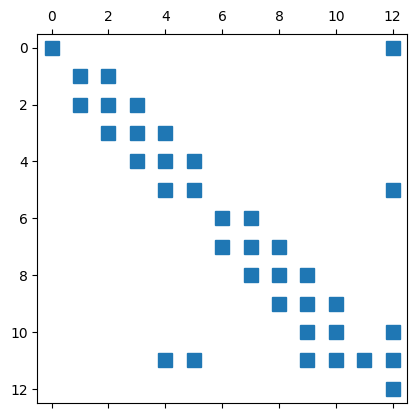

In [18]:
plt.spy(A)

In [19]:
A.todense()

matrix([[ 0.00000000e+00+1.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         -1.57591844e+01+0.j],
        [ 0.00000000e+00+0.j,  8.17798303e+02+1.j, -8.17798303e+02+0.j,
          0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j, -1.16828329e+02+0.j,  5.84141645e+02+1.j,
         -4.67313316e+02+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j,  0.00000000e+

In [20]:
M.todense()

matrix([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [21]:
J.todense()

matrix([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.57591844e+01],
        [ 0.00000000e+00, -8.17798303e+02,  8.17798303e+02,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.16828329e+02, -5.84141645e+02,
          4.67313316e+02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.72168064e+02,
         -5.59546208e+02,  3.87378144e+02,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.0000000

In [22]:
b.todense()

matrix([[ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [-1]])